In [21]:
# Data manipulation
import pandas as pd
import numpy as np
import sqlite3
from transformers import pipeline

# for tracking time
from tqdm import tqdm
tqdm.pandas()

# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import textwrap
from tabulate import tabulate

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, concatenate, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer, TFBertModel


# Text processing
import re
import string
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer


# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 0: Load Models

In [22]:
X_train = pd.read_pickle("./data/X_train.pkl")
X_test = pd.read_pickle("./data/X_test.pkl")
y_train = pd.read_pickle("./data/y_train.pkl")
y_test = pd.read_pickle("./data/y_test.pkl")
df_merged = pd.read_pickle("./data/df_merged.pkl")

## Step 3: Train & Evaluate Models

In [23]:
y_train_classification = y_train['Post_Engagement']
y_test_classification = y_test['Post_Engagement']

y_train_regression = y_train['TotalInteraction']
y_test_regression = y_test['TotalInteraction']

# Function to tokenize and pad the textual data
def preprocess_text_column(column, tokenizer=None, max_len=100):
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(column)
    
    sequences = tokenizer.texts_to_sequences(column)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    return padded_sequences, tokenizer

# Preprocess text columns in train and test sets
max_len = 100
X_train_body, body_tokenizer = preprocess_text_column(X_train['Body'], max_len=max_len)
X_test_body = pad_sequences(body_tokenizer.texts_to_sequences(X_test['Body']), maxlen=max_len, padding='post')

X_train_headline, headline_tokenizer = preprocess_text_column(X_train['Headline'], max_len=max_len)
X_test_headline = pad_sequences(headline_tokenizer.texts_to_sequences(X_test['Headline']), maxlen=max_len, padding='post')

# Scale temporal features in train and test sets
scaler = StandardScaler()
X_train_temporal = scaler.fit_transform(X_train[['publication_time', 'publication_rank']])
X_test_temporal = scaler.transform(X_test[['publication_time', 'publication_rank']])


# Prepare labels
y_train_classification = (y_train_classification == 'top post').astype(int)  
y_test_classification = (y_test_classification == 'top post').astype(int)  


# Function to plot and save feature importance
def plot_feature_importances(features, importances, model_name):
    # Sort features by importance and select top 30
    
    #take only the 30 most important - if we have more than 30
    try:
        top_n = 30
        indices = np.argsort(importances)[::-1][:top_n]
        top_features = np.array(features)[indices]
        top_importances = importances[indices]
    except:
        top_features = np.array(features)
        top_importances = importances
    
    # Set a beautiful plot style
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    plt.barh(top_features, top_importances, color="skyblue", edgecolor="black")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel('Relative Importance')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    
    # Save plot to a file with the model name
    filename = f"./figures/feature_importances_{model_name}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close plot to avoid inline display
    
def train_lstm(model, X_train_body, X_train_headline, X_train_temporal, y):
    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=2,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
        verbose=1            # Verbosity mode
    )
    
    history = model.fit(
        [X_train_body, X_train_headline, X_train_temporal], y,
        epochs=10,  
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]  
    )
    
    return model

In [29]:
n_trees = 100
maxdepth = 10 
minsamplessplit = 20
maxsamplesleaf = 10
maxfeatures='log2'

random_forest_regression = RandomForestRegressor(
                n_estimators=n_trees,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=maxdepth,          # Limit depth to avoid overfitting
                min_samples_split=minsamplessplit,  # the number of samples required to split
                min_samples_leaf=maxsamplesleaf,    # the number of samples required at leaves
                max_features=maxfeatures    # The number of features at each split
            )

random_forest_classification = RandomForestClassifier(
                n_estimators=n_trees,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=maxdepth,          # Limit depth to avoid overfitting
                min_samples_split=minsamplessplit,  # the number of samples required to split
                min_samples_leaf=maxsamplesleaf,    # the number of samples required at leaves
                max_features=maxfeatures    # The number of features at each split
            )

generated_features_wo_sentiment = [col for col in X_train.columns if col not in {
    'ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 
    'Status', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 
    'Subtitle', 'FullText',  'CleanedText', 'sentiment_score'
}]

generated_features = [col for col in X_train.columns if col not in {
    'ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 
    'Status', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 
    'Subtitle', 'FullText', 'CleanedText',
}]

# Define the training function with RandomForestRegressor
def train_explainable_model(features, y_train_regression, regression=True):
    
    if regression:
        model = random_forest_regression 
    else:
        model = random_forest_classification 
    
    
    # Wrap the model fitting in tqdm to track progress
    for _ in tqdm(range(model.n_estimators), desc="Training RandomForest"):
        model.fit(X_train[features], y_train_regression)  # Training step
        
    # Store feature importances
    feature_importances = model.feature_importances_
    
    return model, feature_importances

### Step 3.2: Regression Task

In [5]:



regression_models = {
    'Baseline_Regression': y_train_regression.mean(), 
    #'Explainable_SimpleRegressionModel_RF': ['word_count', 'punctuation_count',
     #                       'unique_words', 'title_length', 'body_length',
      #                     'title_to_body_ratio', 'character_count'],
    'Explainable_ComplexRegressionModel_RF': generated_features_wo_sentiment,
    'Semi_Explainable_ComplexRegression_RF_BERT': generated_features
}

In [6]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units, return_sequences=False)(embedding_body)
dropout_body = Dropout(dropout_rate)(lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units, return_sequences=False)(embedding_headline)
dropout_headline = Dropout(dropout_rate)(lstm_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([dropout_body, dropout_headline, input_temporal])

# Add batch normalization for stability
batch_norm = BatchNormalization()(concatenated)

# Output layer with linear activation for regression
output = Dense(1, activation='linear')(batch_norm)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model with a regression loss function
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models['LSTM_Regression_Model'] = model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 64)      4299392     ['body_input[0][0]']             
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 64)      872960      ['headline_input[0][0]']         
                                                                                              

In [7]:

# Define hyperparameters
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Use Bidirectional LSTM
bi_lstm_body = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_body)
dropout_body = Dropout(dropout_rate)(bi_lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Use Bidirectional LSTM
bi_lstm_headline = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_headline)
dropout_headline = Dropout(dropout_rate)(bi_lstm_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([dropout_body, dropout_headline, input_temporal])

# Add batch normalization for stability
batch_norm = BatchNormalization()(concatenated)

# Output layer with linear activation for regression
output = Dense(1, activation='linear')(batch_norm)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model with a regression loss function
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models['BiLSTM_Regression_Model'] = model


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 64)      4299392     ['body_input[0][0]']             
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 64)      872960      ['headline_input[0][0]']         
                                                                                            

In [8]:



def calculate_regression_metrics(y_true, y_pred):
    """Calculate regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Updated evaluate_model_regression function to include feature importance plotting
def evaluate_model_regression(y_train_regression, y_test_regression, model=None, 
                              predict_baseline=False, explainable=False, lstm=False, 
                              features=None, model_name=None):
    """Evaluate model or baseline regression."""
    if predict_baseline:
        y_pred_train = [y_train_regression.mean()] * len(y_train_regression)
        y_pred_test = [y_train_regression.mean()] * len(y_test_regression)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
        
        # Plot feature importances after training RandomForest
        plot_feature_importances(features, model.feature_importances_, model_name)
        
    elif lstm:
        y_pred_train = model.predict([X_train_body, X_train_headline, X_train_temporal])
        y_pred_test = model.predict([X_test_body, X_test_headline, X_test_temporal])
    
    metrics_train = calculate_regression_metrics(y_train_regression, y_pred_train)
    metrics_test = calculate_regression_metrics(y_test_regression, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

def create_evaluation_df_regression(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'MSE': metrics[0], 'MAE': metrics[1], 'R2': metrics[2]},
        {'Model': model_name, 'Evaluation': 'Test', 'MSE': metrics[3], 'MAE': metrics[4], 'R2': metrics[5]}
    ])

# Evaluate each model
evaluation_regression_dfs = []

for model_name, X_baseline in regression_models.items():
    if 'baseline' in model_name.lower():
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         predict_baseline=True)

    elif 'explainable' in model_name.lower():
        trained_model, feature_importances = train_explainable_model(regression_models[model_name], y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         model=trained_model, explainable=True,
                                                         features=regression_models[model_name], 
                                                         model_name=model_name)
    elif 'lstm' in model_name.lower():
        model = regression_models[model_name]
        trained_model = train_lstm(model, X_train_body, X_train_headline, 
                                              X_train_temporal, y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, model=model, lstm=True)
        
    # Save results
    evaluation_df = create_evaluation_df_regression(model_name, metrics)
    evaluation_regression_dfs.append(evaluation_df)

# Combine evaluation results into one DataFrame
evaluation_regression_dfs = pd.concat(evaluation_regression_dfs, ignore_index=True)
evaluation_regression_dfs_sorted = evaluation_regression_dfs.sort_values(by='Evaluation', ascending=False)


Training RandomForest: 100%|█████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 1/10
800/800 [==============================] - 70s 84ms/step - loss: 171.3414 - mae: 7.5085 - val_loss: 154.8040 - val_mae: 8.5429
Epoch 2/10
800/800 [==============================] - 65s 81ms/step - loss: 153.5170 - mae: 7.5580 - val_loss: 164.5662 - val_mae: 9.6031
Epoch 3/10
800/800 [==============================] - 69s 86ms/step - loss: 146.6298 - mae: 7.3727 - val_loss: 152.8237 - val_mae: 7.5333
Epoch 4/10
800/800 [==============================] - 70s 87ms/step - loss: 138.2156 - mae: 7.0937 - val_loss: 178.9177 - val_mae: 7.0153
Epoch 5/10
800/800 [==============================] - 71s 89ms/step - loss: 125.0730 - mae: 6.6857 - val_loss: 151.4123 - val_mae: 8.2719
Epoch 6/10
800/800 [==============================] - 73s 91ms/step - loss: 115.1754 - mae: 6.3887 - val_loss: 151.1701 - val_mae: 7.9899
Epoch 7/10
800/800 [==============================] - 71s 89ms/step - loss: 122.3910 - mae: 6.6744 - val_loss: 163.5674 - val_mae: 7.0594
Epoch 8/10
800/800 [==============

In [9]:
evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"]

,Model,Evaluation,MSE,MAE,R2
1,Baseline_Regression,Test,163.388836,7.935841,-6.430217e-07
3,Explainable_ComplexRegressionModel_RF,Test,155.304111,7.655808,4.948089e-02
5,Semi_Explainable_ComplexRegression_RF_BERT,Test,154.971110,7.647391,5.151898e-02
7,LSTM_Regression_Model,Test,156.550648,7.914234,4.185162e-02
9,BiLSTM_Regression_Model,Test,151.319512,7.670986,7.386813e-02


In [10]:
X_train[["FullText", "Headline"]].head(100).style

,FullText,Headline
0,Warum ist im Standard darüber nichts zu lesen ? in vielen deutschen Medien aber schon ? Blattlinie ?,
1,Niemand hat die Absicht eine Mauer zu errichten. Hahaha.....,Niemand hat die Absicht eine Mauer zu errichten.
2,Bin ich jetzt auf heute.at gelandet dachte das ist der Standard!,Bin ich jetzt auf heute.at gelandet dachte das ist der Standard!
3,"Pardon, Schlüsse wären (nicht) zu ziehen, nicht Schüsse.",
4,Für Zäune mit eu müsste ich mich selbst rot stricheln .....,Für Zäune mit eu müsste ich mich selbst rot stricheln .....
5,"Hab ich das richtig verstanden? Im eigenen Staat schafft man es nicht, eine gerechte und funktionierende Aufteilung der Flüchtlinge auf die Länder durchzusetzen, aber die EU wird jetzt geklagt, dass sie es nicht macht. Ich erinnere noch sehr gut, es war vor recht genau einem Jahr und das Thema ""Länder gesetzlich verpflichten"" war aktuell. Im Interview wies Mikl-Leitner ebendiese Idee entrüstet zurück, weil die Länder da keine Bevormundung vom Bund brauchen. Das Ergebnis ein Jahr später kann jeder sehen. Diese Dame ist eine Zumutung!!!",Hab ich das richtig verstanden?
6,"Eben. Insofern ist es ziemlich realitätsfern, hier Quoten zu verlangen, oder zu glauben dass sich das mit anderen Mitteln durchsetzen lässt als die der Ungarn, die man ja nicht einsetzen möchte.",
7,"Frag mich, ob die no border Ideologen vergessen haben, wer sie gewaehlt hat.",
8,Angeblich wird jetzt das Lager geräumt und sie kommen in andere griechische Unterkünfte. Lt. ARD Tagesschau weigern sich aber die Menschen wo anders hinzugehen!,
9,"es wird massive Gewinne für die Blauen geben - einfach und allein auf Grund der Tatsache der aktuelle Situation bzgl. Ausländer. Das bewegt und emotionalisiert, schafft Feindbilder, etc. Aber hoffentlich wird erkannt, dass Politik so viele Aufgabengebiete hat, wofür die Blauen keine nachhaltige Lösungen anbieten!",


In [11]:
X_train.columns

Index(['ID_Post', 'ID_Article', 'ID_User', 'CreatedAt', 'Status', 'Headline',
       'Body', 'Path', 'publishingDate', 'Title',
       ...
       'ngram_einfach mal', 'ngram_problem nicht', 'ngram_nämlich nicht',
       'ngram_land nicht', 'ngram_gegen flüchtlinge', 'ngram_asyl ansuchen',
       'ngram_de facto', 'ngram_verstehe nicht', 'ngram_zeit link',
       'ngram_eu kommission'],
      dtype='object', length=407)

In [12]:

latex_table = tabulate(evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"], 
                       headers='keys', tablefmt='latex', showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

\begin{tabular}{llrrr}
\hline
 Model                                      & Evaluation   &       MSE &     MAE &           R2 \\
\hline
 Baseline\_Regression                        & Test         & 163.38884 & 7.93584 & -6.43022e-07 \\
 Explainable\_ComplexRegressionModel\_RF      & Test         & 155.30411 & 7.65581 &  0.0494809   \\
 Semi\_Explainable\_ComplexRegression\_RF\_BERT & Test         & 154.97111 & 7.64739 &  0.051519    \\
 LSTM\_Regression\_Model                      & Test         & 156.55065 & 7.91423 &  0.0418516   \\
 BiLSTM\_Regression\_Model                    & Test         & 151.31951 & 7.67099 &  0.0738681   \\
\hline
\end{tabular}


### Step 3.1: Classification Task

In [30]:
classification_models = {
    'Baseline_Classification': y_train_regression.mean(), 
    #'Explainable_SimpleClassificationModel_RF': ['word_count', 'punctuation_count',
      #                      'unique_words', 'title_length', 'body_length',
       #                    'title_to_body_ratio', 'character_count'],
    'Explainable_ComplexClassificationModel_RF': generated_features_wo_sentiment,
    'Semi_Explainable_Classification_RF_BERT': generated_features
}

In [31]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units)(embedding_body)
# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units)(embedding_headline)
# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')
# Concatenate all inputs
concatenated = concatenate([lstm_body, lstm_headline, input_temporal])
# Output layer
output = Dense(1, activation='sigmoid')(concatenated)
# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


classification_models['LSTM_Classification_Model'] = model



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 100, 64)      4299392     ['body_input[0][0]']             
                                                                                                  
 embedding_15 (Embedding)       (None, 100, 64)      872960      ['headline_input[0][0]']         
                                                                                            

In [27]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Use Bidirectional LSTM
bi_lstm_body = Bidirectional(LSTM(lstm_units))(embedding_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Use Bidirectional LSTM
bi_lstm_headline = Bidirectional(LSTM(lstm_units))(embedding_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([bi_lstm_body, bi_lstm_headline, input_temporal])

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(concatenated)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Add the model to the classification models dictionary
classification_models['BiLSTM_Classification_Model'] = model


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 100, 64)      4299392     ['body_input[0][0]']             
                                                                                                  
 embedding_13 (Embedding)       (None, 100, 64)      872960      ['headline_input[0][0]']         
                                                                                            

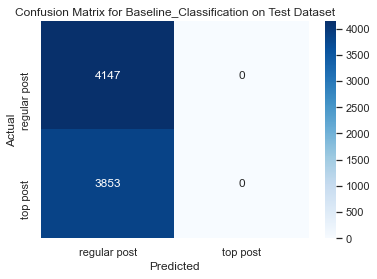

Training RandomForest: 100%|█████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


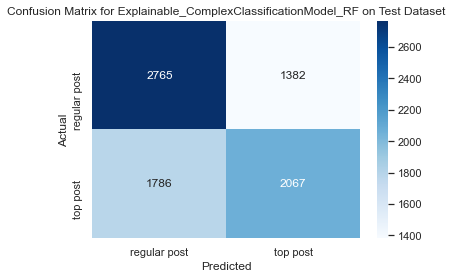

Training RandomForest: 100%|█████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


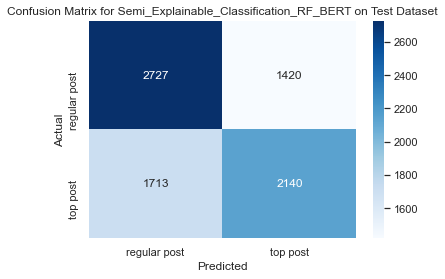

Epoch 1/10
800/800 [==============================] - 74s 89ms/step - loss: 0.6624 - accuracy: 0.5939 - val_loss: 0.6596 - val_accuracy: 0.5970
Epoch 2/10
800/800 [==============================] - 69s 86ms/step - loss: 0.6513 - accuracy: 0.6042 - val_loss: 0.6633 - val_accuracy: 0.5922
Epoch 3/10
800/800 [==============================] - 69s 86ms/step - loss: 0.6248 - accuracy: 0.6199 - val_loss: 0.6926 - val_accuracy: 0.5866
Epoch 3: early stopping
250/250 [==============================] - 5s 19ms/step


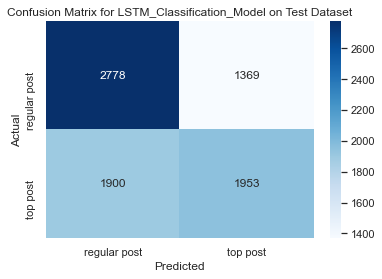

                                       Model Evaluation  Accuracy  Precision  \
0                    Baseline_Classification      Train  0.520969   0.000000   
2  Explainable_ComplexClassificationModel_RF      Train  0.629875   0.624509   
4    Semi_Explainable_Classification_RF_BERT      Train  0.632563   0.624002   
6                  LSTM_Classification_Model      Train  0.597125   0.589827   
1                    Baseline_Classification       Test  0.518375   0.000000   
3  Explainable_ComplexClassificationModel_RF       Test  0.604000   0.599304   
5    Semi_Explainable_Classification_RF_BERT       Test  0.608375   0.601124   
7                  LSTM_Classification_Model       Test  0.591375   0.587899   

     Recall        F1  
0  0.000000  0.000000  
2  0.570161  0.596099  
4  0.586144  0.604481  
6  0.521952  0.553817  
1  0.000000  0.000000  
3  0.536465  0.566146  
5  0.555411  0.577364  
7  0.506878  0.544390  


In [32]:
def calculate_classification_metrics(y_true, y_pred):
    """Calculate classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['regular post', 'top post'], 
                yticklabels=['regular post', 'top post'])
    plt.title(f'Confusion Matrix for {model_name} on Test Dataset')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_model_classification(y_train_classification, y_test_classification, model=None, 
                                  predict_baseline=False, 
                                  explainable=False,
                                  lstm=False,
                                  features=None, model_name=None):
    """Evaluate model or baseline classification."""
    if predict_baseline:
        y_pred_train = [0] * len(y_train_classification)
        y_pred_test = [0] * len(y_test_classification)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
        # Convert to binary predictions
        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        # Plot feature importances after training RandomForest
        plot_feature_importances(features, model.feature_importances_, model_name)
        
    elif lstm:
        y_pred_train = (model.predict([X_train_body, X_train_headline, X_train_temporal]) > 0.5).astype(int)
        y_pred_test = (model.predict([X_test_body, X_test_headline, X_test_temporal]) > 0.5).astype(int)
    
    metrics_train = calculate_classification_metrics(y_train_classification, y_pred_train)
    metrics_test = calculate_classification_metrics(y_test_classification, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

    

def create_evaluation_df_classification(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'Accuracy': metrics[0], 'Precision': metrics[1], 'Recall': metrics[2], 'F1': metrics[3]},
        {'Model': model_name, 'Evaluation': 'Test', 'Accuracy': metrics[4], 'Precision': metrics[5], 'Recall': metrics[6], 'F1': metrics[7]}
    ])




# Evaluate each model and plot confusion matrix
evaluation_dfs_classification = []
examples_df = pd.DataFrame(columns=['ModelName',  # which model
                                    'Type', #weather true positive (tp), true negative (tn), fp or fn
                                    'Example', # the body of that example
                                    'PositiveVotes',
                                    'NegativeVotes'])

for model_name, X_baseline in classification_models.items():
    
    if 'baseline' in model_name.lower():
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, predict_baseline=True)

    elif 'explainable' in model_name.lower():
        trained_model, feature_importances = train_explainable_model(classification_models[model_name], y_train_classification)
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, 
                                                         model=trained_model, explainable=True,
                                                         features=classification_models[model_name], 
                                                         model_name=model_name)
    elif 'lstm' in model_name.lower():
        model = classification_models[model_name]
        trained_model = train_lstm(model, X_train_body, X_train_headline, 
                                                  X_train_temporal, y_train_classification)
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, model=model, lstm=True)
        
    # save results
    evaluation_df = create_evaluation_df_classification(model_name, metrics)
    evaluation_dfs_classification.append(evaluation_df)
    

    # Plot confusion matrix for test dataset
    plot_confusion_matrix(y_test_classification, y_pred_test, model_name)

    # Collect examples of each kind (tp, tn, fp, fn)
    examples = {'True Positive': None, 'True Negative': None, 'False Negative': None, 'False Positive': None}
    for i in range(len(y_test_classification)):
        example_data = {
            'ModelName': model_name,
            'Example': df_merged['Body'].iloc[X_test.index[i]],
            'PositiveVotes': df_merged['PositiveVotes'].iloc[X_test.index[i]],
            'NegativeVotes': df_merged['NegativeVotes'].iloc[X_test.index[i]]
        }
        if y_test_classification.iloc[i] == 1:
            if y_pred_test[i] == 1 and examples['True Positive'] is None:
                examples['True Positive'] = {**example_data, 'Type': 'True Positive'}
            elif y_pred_test[i] == 0 and examples['False Negative'] is None:
                examples['False Negative'] = {**example_data, 'Type': 'False Negative'}
        elif y_pred_test[i] == 1 and examples['False Positive'] is None:
            examples['False Positive'] = {**example_data, 'Type': 'False Positive'}
        elif y_pred_test[i] == 0 and examples['True Negative'] is None:
            examples['True Negative'] = {**example_data, 'Type': 'True Negative'}
    # Append collected examples to examples_df
    for example_type, example in examples.items():
        if example is None:
            example = {
                'ModelName': model_name,
                'Type': example_type,
                'Example': None,
                'PositiveVotes': None,
                'NegativeVotes': None
            }
        examples_df = examples_df.append(example, ignore_index=True)
        
        

# Combine evaluation results into one DataFrame
evaluation_dfs_classification = pd.concat(evaluation_dfs_classification, ignore_index=True)
evaluation_dfs_classification_sorted = evaluation_dfs_classification.sort_values(by='Evaluation', ascending=False)
print(evaluation_dfs_classification_sorted)


In [33]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline_Classification,Test,0.518375,0.000000,0.000000,0.000000
3,Explainable_ComplexClassificationModel_RF,Test,0.604000,0.599304,0.536465,0.566146
5,Semi_Explainable_Classification_RF_BERT,Test,0.608375,0.601124,0.555411,0.577364
7,LSTM_Classification_Model,Test,0.591375,0.587899,0.506878,0.544390


In [ ]:
latex_table = tabulate(evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"], 
                       headers='keys', tablefmt='latex', showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

In [ ]:
examples_df

In [ ]:

def format_example_text(example_text, pos_votes, neg_votes):
    """Format example text to display only the first 100 characters with line breaks every 25 characters."""
    if example_text:
        # Limit to 100 characters
        truncated_text = example_text[:100]
        # Create line breaks every 25 characters without cutting words
        wrapped_text = textwrap.fill(truncated_text, width=25)
        return f"{wrapped_text}\n(Pos: {pos_votes}, Neg: {neg_votes})"
    return "No Example"

def plot_confusion_matrix_of_examples(examples_df, model_name):
    """Plot the confusion matrix using the examples dataframe."""
    labels = ['Regular Post', 'Top Post']
    cm = [[0, 0], [0, 0]]  # Initialize confusion matrix counts

    # Fill confusion matrix based on examples_df
    for _, row in examples_df.iterrows():
        if row['Type'] == 'True Positive':
            cm[1][1] += 1
        elif row['Type'] == 'True Negative':
            cm[0][0] += 1
        elif row['Type'] == 'False Positive':
            cm[0][1] += 1
        elif row['Type'] == 'False Negative':
            cm[1][0] += 1

    plt.figure(figsize=(10, 8))  # Increase the overall size

    # Create a grid for the confusion matrix
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            # Draw rectangle for each cell
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))
            # Only annotate if there's a count
            if cm[i][j] > 0:
                # Find the corresponding example
                example_row = examples_df[(examples_df['Type'] == ('True Positive' if i == 1 and j == 1 else
                                                                    'True Negative' if i == 0 and j == 0 else
                                                                    'False Positive' if i == 0 and j == 1 else
                                                                    'False Negative'))]
                
                # Fetch the corresponding example text
                if not example_row.empty:
                    example = example_row.iloc[0]
                    formatted_text = format_example_text(example['Example'], 
                                                          example['PositiveVotes'], 
                                                          example['NegativeVotes'])
                else:
                    formatted_text = "No Example"
                    
                # Place the text in the center of each cell
                plt.text(j + 0.5, i + 0.5, formatted_text, ha='center', va='center', 
                         fontsize=13, color='black')

    # Set axis limits and labels
    plt.xlim(0, len(cm[0]))
    plt.ylim(0, len(cm))
    plt.title(f'Confusion Matrix with Examples for {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks([0.5, 1.5], labels, fontsize=12)
    plt.yticks([0.5, 1.5], labels, fontsize=12)
    plt.gca().invert_yaxis()  # Invert y axis to have the origin in the top left

    plt.grid(False)  # Disable the grid
    plt.axis('on')  # Show the axes
    plt.show()

# Example call to plot the confusion matrix using examples_df
for model_name in examples_df['ModelName'].unique():
    model_examples_df = examples_df[examples_df['ModelName'] == model_name]
    plot_confusion_matrix_of_examples(model_examples_df, model_name)
